$\setcounter{secnumdepth}{0}$

## Completed by:   
*   Denys Botuk

In [1]:
import math
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from scipy.special import beta
from scipy.optimize import minimize

warnings.simplefilter(action='ignore', category=FutureWarning)

# Problem 4: Inferential statistics

## 1. The objective of this part is to get a better feeling for the ML estimation procedure. Consider the daily UAH/Euro exchange rate for the last year. The data can be downloaded, for example, from www.investing.com. Financial data typically has heavy tails and better fits the t-distribution, than the normal distribution.

Let's download the historical data from www.investing.com about EUR/UAH exchange rates and look at them:

In [2]:
rate_data = pd.read_csv('EUR_UAH Historical Data.csv')
rate_data

,Date,Price,Open,High,Low,Vol.,Change %
0,03/11/2023,38.7317,38.5615,39.1237,38.4311,NaN,0.75%
1,02/11/2023,38.4444,38.4184,38.9694,38.3965,NaN,0.09%
2,01/11/2023,38.4094,38.3836,38.8150,38.2029,NaN,0.32%
3,31/10/2023,38.2851,38.6423,39.1202,38.3165,NaN,-0.62%
4,30/10/2023,38.5252,38.5078,38.7575,38.3493,NaN,0.13%
...,...,...,...,...,...,...,...
256,10/11/2022,37.6981,36.9783,37.7539,36.5192,130.24K,1.96%
257,09/11/2022,36.9743,36.9888,37.2570,36.6936,119.36K,0.58%
258,08/11/2022,36.7628,36.7960,37.1291,36.6562,100.71K,0.53%
259,07/11/2022,36.5694,36.4880,37.0091,36.3966,94.51K,0.06%


So, here we have exchange rates between EUR/UAH for each working day during last year. We will be interesting in the data from column 'Price'. Data from 'Change %' will be also useful for our analysis.

Now, look at the prices data, plotting histogram:

In [3]:
prices = rate_data['Price']

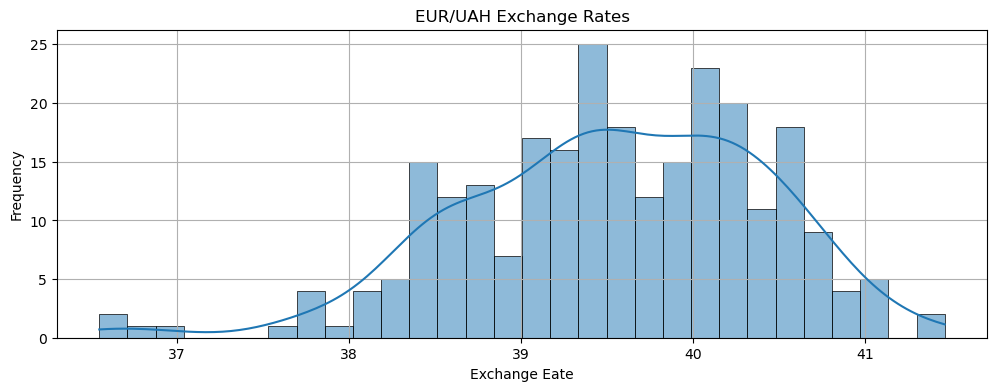

In [4]:
plt.figure(figsize=(12, 4));
sns.histplot(prices, bins=30, kde=True, linewidth=0.5)
plt.title('EUR/UAH Exchange Rates')
plt.xlabel('Exchange Eate')
plt.ylabel('Frequency')
plt.rc('axes', axisbelow=True)
plt.grid()

Here, we can see that the data are left-skewed. So, the mean is expected to be less than median.
Let's take a look at some main characteristics of this sample:

In [5]:
rate_data['Price'].describe()

count    261.000000
mean      39.533846
std        0.869929
min       36.548200
25%       38.951600
50%       39.576600
75%       40.173100
max       41.462300
Name: Price, dtype: float64

As expected the mean is a little bit less than mean. 

Standard deviation is very small. 

The range of prices inside the sample is $4.92$.

50% of the observations in this sample is between $38.95$ and $40.17$. $IQR = 1.22$.

### _(a) Compute the log-returns of the exchange rate: $r_t = ln(\frac{ex_t}{ex_{t−1}})$, where $ex_t$ is the exchange rate on day $t$. Using your software run a suitable goodness-of-fit test (for example, Kolmogorov-Smirnov) to verify if the data is normally distributed. Write down the hypotheses, the test statistics and the $p$-value. What do we conclude?_

We are interested in analysis of exchange rates inside the sample. So, for this purpose data from "Change %" column will be useful.

But first let make an float value without "%" symbol for the data from this column. 

In [6]:
rate_data['Change %'] = rate_data['Change %'].apply(lambda x: float(x.split('%')[0].strip()))
rate_data

,Date,Price,Open,High,Low,Vol.,Change %
0,03/11/2023,38.7317,38.5615,39.1237,38.4311,NaN,0.75
1,02/11/2023,38.4444,38.4184,38.9694,38.3965,NaN,0.09
2,01/11/2023,38.4094,38.3836,38.8150,38.2029,NaN,0.32
3,31/10/2023,38.2851,38.6423,39.1202,38.3165,NaN,-0.62
4,30/10/2023,38.5252,38.5078,38.7575,38.3493,NaN,0.13
...,...,...,...,...,...,...,...
256,10/11/2022,37.6981,36.9783,37.7539,36.5192,130.24K,1.96
257,09/11/2022,36.9743,36.9888,37.2570,36.6936,119.36K,0.58
258,08/11/2022,36.7628,36.7960,37.1291,36.6562,100.71K,0.53
259,07/11/2022,36.5694,36.4880,37.0091,36.3966,94.51K,0.06


To make the data more convenient to work with, let's make it more symmetric, computing the log-returns value $r_t = ln(\frac{ex_t}{ex_{t−1}})$ using "Change %" by the formula $r_t = ln(1 + \frac{change_t}{100})$:

In [7]:
returns = np.array(rate_data['Change %']) / 100 + 1
log_returns = np.log(returns)

Now we are interested in the distribution family of the log-returns data.

Kolmogorov-Smirnov is appropriate Goodness-of-Fit test. So, we will use it to verify if the log-returns data is normally distributed.

Let, $r_t \sim F$, where $F$ - distribution of $r_t$, $\mu_0$ - mean of $r_t$, $\sigma_0^2$ - variance of $r_t$.

First, define hypothesis:

$H_0: F = N(\mu_0, \sigma_0^2)$ - distribution of log-returns is normal.

$H_1: F \neq N(\mu_0, \sigma_0^2)$ - distribution of log-returns is NOT normal.

First, calculate test statistics, which can be computed by the following formula:
$$D = \max\limits_{x \in \mathbb{R}}|\hat F(x) - F_0(x)|$$

In [8]:
rate_statistic, rate_p_value = st.kstest(log_returns, 'norm', args=(log_returns.mean(), log_returns.std()))
rate_statistic, rate_p_value

(0.061832834587699614, 0.2602675233350302)

Let significance value $\alpha$ equal to 5% (0.05).

So, as $p$-value is greater than $\alpha$, then with significance level of $5\%$ ($95\%$ of confidence) we haven't enough evidence to reject the null hypothesis.

Therefore, we can't conclude that log-returns data are not normally distributed based on the current sample and using Kolmogorov-Smirnov test.

### _(b) Now assume that the returns follow a (generalized) $t$-distribution with some unknown degree of freedom. The density function of the $t_{df}$-distribution is given by_

### _$$f(x) = \frac{(1 + \frac{1}{df}(\frac{x-\mu}{\sigma})^2)^{-\frac{df+1}{2}}}{B(\frac{df}{2},\frac{1}{2})\sqrt{df}\sigma}$$_

### _where $B(·,·)$ is the beta function (beta(a,b) in R.) Write a code for the log-likelihood function evaluated at the sample of returns, i.e._

### _$$ln L(\mu, \sigma, df)=\sum\limits_{t=1}^{T}ln\left(\frac{(1 + \frac{1}{df}(\frac{r_t-\mu}{\sigma})^2)^{-\frac{df+1}{2}}}{B(\frac{df}{2},\frac{1}{2})\sqrt{df}\sigma}\right)$$_

### _and maximize it w.r.t. ($\mu$, $\sigma$, $df$). Use a build-in optimization function. Note, that $\sigma > 0$ and $df > 0$._

Assume that the returns follow a $t$-distribution with some unknown degree of freedom.

Define the density function of the $t_{df}$-distribution by the following formula:
$$f(x) = \frac{(1 + \frac{1}{df}(\frac{x-\mu}{\sigma})^2)^{-\frac{df+1}{2}}}{B(\frac{df}{2},\frac{1}{2})\sqrt{df}\sigma}$$

In [9]:
def t_dist_density(mu, sigma, df, data):
    return (1 + 1/df * ((data - mu)/sigma)**2)**(-(df + 1)/2) / (beta(df/2, 1/2) * math.sqrt(df) * sigma)

Now, define likelihood function $L_{\mu, \sigma, df}(r)$, by the following formula:
$$L_{\mu, \sigma, df}(r) = \prod\limits_{t=1}^T \frac{(1 + \frac{1}{df}(\frac{r_t-\mu}{\sigma})^2)^{-\frac{df+1}{2}}}{B(\frac{df}{2},\frac{1}{2})\sqrt{df}\sigma}$$

$L_{\mu, \sigma, df}(r)$ is the probability that we observe the particular sample assuming that the underlying parameters equal to $\mu$, $\sigma$ and $df$.

As our purpose is to find maximum likelihood estimation of the parameters, then we will need to compute derivatives, so to make it easier, let take a $log$ of $L_{\mu, \sigma, df}(r)$:
$$ln L_{\mu, \sigma, df}(r)=\sum\limits_{t=1}^{T}ln\left(\frac{(1 + \frac{1}{df}(\frac{r_t-\mu}{\sigma})^2)^{-\frac{df+1}{2}}}{B(\frac{df}{2},\frac{1}{2})\sqrt{df}\sigma}\right)$$

In [10]:
def log_likelihood_func(x, data):
    mu, sigma, df = x
    return -np.sum(np.log(t_dist_density(mu, sigma, df, data)))

Let initial values of parameters: $\mu_0 = \overline{r_t}$, $\sigma_0 = S_{r_t}$ and $df_0 = 1$.

Also consider bounds that $\sigma > 0$ and $df > 0$.

So, let's find maximum of the function (software library includes only minimize method, that's why we set minus $ln(f(x))$ previously and will find a minimum of such function, that is actually the maximum of the original function):

In [11]:
initial = [log_returns.mean(), log_returns.std(), 1]  # mu, sigma, df

result = minimize(log_likelihood_func, initial, args=log_returns, bounds=[(None, None), (0, None), (0, None)])
result.x

array([5.12919408e-04, 6.06017644e-03, 8.10367250e+00])

So, if we assume that log-returns data follow $t$-distribution, then $f(x)$ with parameters $\mu_0 = 0.00051$, $\sigma_0 = 0.00606$ and $df_0 = 8.10367$ will describe our sample in the best way.

## 2. Here we run a few tests for the data used in the first assignment. For every test write down: the two hypotheses; the formula for the test statistic with inserted values; rejection area computed manually; $p$-value from your software; your decision and the verbal conclusion (not just sth like “$H_0$ is rejected”). Use for all tests $\alpha = 5\%$.

Let, download the data from CEO dataset:

In [12]:
ceo_data = pd.read_excel('ceo.xlsx')

ages = np.array(ceo_data['age'])
salaries = np.array(ceo_data['salary'])
sales = np.array(ceo_data['sales'])
profits = np.array(ceo_data['profits'])

Set significance level for all following test to $5\%$:

In [13]:
alpha = 0.05

### _(a) We argue that the expected age of a CEO is higher than $60$ years. Can this be confirmed with an appropriate test?_

As we need to estimate mean value and we don't know the value of variance, so the appropriate test to run will be T-test.

First, define hypotheses for test:

$H_0: \mu \leq 60$ - expected age of a CEO is less or equal than 60 years 

$H_1: \mu > 60$ - expected age of a CEO is higher than 60 years 

Then according to the T-test:

- we estimate $\sigma^2$ by $S^2$

- test statistics will be equal to $V = \sqrt{n}\frac{\bar{X} - \mu_0}{s} \sim t_{n-1}$

- as we will use right-sided test, the rejection area will be equal to $B = (t_{n-1;1-\alpha};+\infty)$

First, let's define rejection area, so find value of $t_{n-1;1-\alpha}$:

In [14]:
st.t.ppf(1 - alpha, len(ages)-1)

1.6482773005072497

So, rejection area is $B = (1.6482;+\infty)$

Let's compute test statistics:

In [15]:
age_mu = 60

age_statistics = math.sqrt(len(ages)) * (np.mean(ages) - age_mu) / np.std(ages)
age_statistics

-10.977582610457409

As test statistics is not in rejection area, we can't reject $H_0$.

Let's check it also using $p$-value.

Now, find $p$-value for this test statistics. As we have right-sided test, $p$-value will be calculated by the following formula:
$$p = 1 - \hat{F}(V)$$

In [16]:
age_pvalue = 1 - st.t.cdf(age_statistics, len(ages) - 1)
age_pvalue

1.0

So, as $p$-value is greater than $\alpha$, then with significance level of $5\%$ ($95\%$ of confidence) we have not enough evidences to reject $H_0$. Therefore, we can't confirm that the expected age of CEO is higher than 60 years.

### _(b) We would like to check if the salary of CEOs that are younger than $60$ is significantly different from the expected salary of CEOs older than $60$. Assume that the variances are unknown and not necessarily equal._

Now we want to compare salary of two groups of CEO: younger than 60 and older ones. 

First, let separate it from the general sample:

In [17]:
salary_younger_60 = ceo_data[ceo_data['age'] < 60]['salary']
salary_older_60 = ceo_data[ceo_data['age'] >= 60]['salary']

As variances ($\sigma_1^2$ and $\sigma_2^2$) are unknown and not necessarily equal, then an appropriate test for such purpose will be asymptotic two-sample Z-test:

$H_0: \mu_1 = \mu_2$ - the salary of CEOs that are younger than  $60$ is similar to the expected salary of CEOs older than  60

$H_1: \mu_1 \neq \mu_2$ - the salary of CEOs that are younger than  $60$ is significantly different from the expected salary of CEOs older than  60

- so, we estimate $\sigma_1^2$ by $S_1^2$ and $\sigma_2^2$ by $S_2^2$

- test statistics will be equal to $V = \frac{\bar{X} - \bar{Y}}{\sqrt{\frac{S_1^2}{n_1} - \frac{S_2^2}{n_2}}} 
\overset{approx.}{\sim} N(0, 1)$

- for two sided test the rejection area will be equal to $B = (-\infty; -Z_{1-\frac{\alpha}{2}}) \cup (Z_{1-\frac{\alpha}{2}}; +\infty)$

First, let's define rejection area, so find value of $Z_{1-\frac{\alpha}{2}}$:

In [18]:
st.norm.ppf(1 - alpha/2)

1.959963984540054

So, rejection area is $B = (-\infty;-1.9599) \cup (1.9599;+\infty)$

Let's compute test statistics:

In [19]:
salaries_statistic = (np.mean(salary_older_60) - np.mean(salary_younger_60)) / \
    math.sqrt(np.var(salary_older_60) / len(salary_older_60) - np.var(salary_younger_60) / len(salary_younger_60))
salaries_statistic

2.6453856427062306

As test statistics is in rejection area, we will reject $H_0$, accepting $H_1$.

Let's check it also using $p$-value.

Let's compute $p$-value for this test statistics. As we have two-sided test, $p$-value will be calculated by the following formula:
$$p = 2\cdot(1 - \hat{F}(V))$$

In [20]:
salaries_p_value = 2 * (1 - st.norm.cdf(salaries_statistic))
salaries_p_value

0.008159786279517078

So, as $p$-value less than $\alpha$, then with significance level of $5\%$ ($95\%$ of confidence) we can reject $H_0$. So, we can conclude that the salary of CEOs that are younger than  $60$ is significantly different from the expected salary of CEOs older than $60$.

### _(c) We suspect that the sales are not related to the profits. Check this using the Pearson correlation coefficient._

Now let's check the relationship between sales and profits. Let's define the hypotheses:

$H_0: \rho = 0$ - sales are not linearly related to the profits.

$H_1: \rho \neq 0$ - sales and profits are linearly dependent.

An appropriate test is Pearson correlation test:

- so, we will estimate $\rho$ by $r_{XY}=\hat{\rho}$:
$$r_{XY} = \hat{\rho} = \frac{S_{XY}}{S_XS_Y} = \frac{\sum\limits_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum\limits_{i=1}^{n}(x_i - \bar{x})^2\sum\limits_{i=1}^{n}(y_i - \bar{y})^2}}$$

- test statistics will be equal to $V = \sqrt{n-2}\frac{\hat{\rho}}{\sqrt{1-\hat{\rho}}} 
\overset{approx.}{\sim} N(0, 1)$

- for two-sided test the rejection area will be equal to $B = (-\infty; -t_{n-2;1-\frac{\alpha}{2}}) \cup (t_{n-2;1-\frac{\alpha}{2}}; +\infty)$

First, let's define rejection area, so find value of $t_{n-2;1-\frac{\alpha}{2}}$:

In [21]:
st.t.ppf(1 - alpha/2, len(ceo_data) - 2)

1.965309213413216

So, rejection area is $B = (-\infty;-1.9653) \cup (1.9653;+\infty)$

Then compute the value of Pearson correlation coefficient:

In [1]:
n = len(ceo_data)
mean_sales = np.mean(sales)
mean_profits = np.mean(profits)

r = (np.sum((sales - mean_sales) * (profits - mean_profits))) / \
     math.sqrt(np.sum((sales - mean_sales)**2) * (np.sum((profits - mean_profits)**2)))

r

NameError: name 'ceo_data' is not defined

Find the test statistics:

In [23]:
corr_statistics = math.sqrt(n - 2) * r / math.sqrt(1 - r)
corr_statistics

29.25498115467614

As test statistics is in rejection area, we will reject $H_0$, accepting $H_1$.

Let's check it also using $p$-value.

Based on this value, let's find $p$-value. As we have two-sided test, $p$-value will be calculated by the following formula:
$$p = 2\cdot(1 - \hat{F}(V))$$

In [24]:
corr_pvalue = (1 - st.t.cdf(corr_statistics, n - 2)) * 2
corr_pvalue

0.0

So, as $p$-value is less than $\alpha$, then with significance level of $5\%$ ($95\%$ of confidence) we can reject $H_0$. So, we can conclude that the sales of CEOs are linearly dependent on the profits.

### _(d) Test if the fraction of CEOs older than 60 is significantly higher than $50\%$._

Now, let's investigate the fraction of CEOs, older than 60. 

First, separate CEOs older than 60:

In [25]:
older_60 = ceo_data[ceo_data['age'] > 60]

To analyse fraction, we need to run proportion test.

First, define hypotheses for test:

$H_0: p \leq 50\%$ - fraction of CEOs older than 60 is significantly higher than 50%.

$H_1: p > 50\%$ - fraction of CEOs older than 60 is less or equal than 50%.

Then according to the this test:

- we estimate $\hat{p}$ by $\bar{x}$

- test statistics will be equal to $V = \sqrt{n}\frac{\bar{x} - p_0}{\sqrt{p_0(1 - p_0)}} \overset{approx.}{\sim} N(0, 1)$

- as we will use right-sided test, the rejection area will be equal to $B = (Z_{1-\alpha};+\infty)$

First, let's define rejection area, so find value of $Z_{1-\alpha}$:

In [26]:
st.norm.ppf(1 - alpha)

1.6448536269514722

So, rejection area is $B = (1.6448;+\infty)$

Let's compute test statistics:

In [27]:
n = len(ceo_data)
p_0 = 0.5
p = len(older_60) / n

test_statistics = math.sqrt(n) * (p - p_0) / math.sqrt(p_0 * (1 - p_0))
test_statistics

-9.790764035696323

As test statistics is not in rejection area, we can't reject $H_0$.

Let's check it also using $p$-value.

Calculate $p$-value for this test statistics. As we have right-sided test, $p$-value will be calculated by the following formula:
$$p = 1 - \hat{F}(V)$$

In [28]:
pvalue = 1 - st.norm.cdf(test_statistics)
pvalue

1.0

As we get $p$-value, which is greater than $\alpha$, thus, we can't reject $H_0$ with significance level of $5\%$ ($95\%$ of confidence) as we don't have significant evidence. It means, that we can't conclude that the fraction of CEOs older than 60 is significantly higher than 50%.

### _(e) All the above tests rely on the normality assumption of salary. Check this assumption using the Kolmogorov-Smirnov test. Use only built-it functions, no manual computations here._

Now we are interested in the distribution family of the salaries data.

Kolmogorov-Smirnov is appropriate Goodness-of-Fit test. So, we will use it to verify if the salaries data is normally distributed.

Let, $x_i \sim F$, where $F$ - distribution of $x_i$, $\mu_0$ - mean of $x_i$, $\sigma_0^2$ - variance of $x_i$.

First, define hypothesis:

$H_0: F = N(\mu_0, \sigma_0^2)$ - distribution of salaries is normal.

$H_1: F \neq N(\mu_0, \sigma_0^2)$ - distribution of salaries is NOT normal.

Calculate test statistics, which can be computed by the following formula:
$$D = \max\limits_{x \in \mathbb{R}}|\hat F(x) - F_0(x)|$$

In [29]:
ks_statistic, pvalue = st.kstest(salaries, 'norm', args=(salaries.mean(), salaries.std()))
ks_statistic, pvalue

(0.1861560957439804, 4.932101822403862e-14)

Here we have $p$-value, which is close to $0$, so it's less than $\alpha$. Thus, we reject $H_0$ with significance level of $5\%$ ($95\%$ of confidence). It means, that we can conclude that salaries aren't normally distributed.

## 3. The next objective is check if the probability of type $1$ error (size of a test) is correctly attained by a simple two-sided test for the mean.

### _(a) Simulate a sample of length $n=100$ from a normal distribution with mean $\mu_0=500$ and variance $\sigma^2=50$. (Note: you may use the transformation $X=\mu+\sigma Z$, where $Z\sim N(0,1)$) The objective is to test the null hypothesis $H_0$ : $\mu=500$. Assume that $\sigma^2$ has to be estimated. Compute the test statistics using the formulas in the lecture; determine the rejection area for $\alpha=0.04$ and decide if $H_0$ can be rejected._

First of all, let's generate the sample of size $n=100$, such that $X_i \sim N(500, 50)$:

In [30]:
n = 100
mu_0 = 500
sigma = math.sqrt(50)
alpha = 0.04
norm_sample = np.random.normal(loc=mu_0, scale=sigma, size=n) # loc - mean, scale - std

$H_0: \mu = 500$

$H_1: \mu \neq 500$

as variance of the distribution ($\sigma^2$) is unknown, so we will use T-test:

- so, we will estimate $\sigma^2$ by $S^2$

- test statistics will be equal to $V = \sqrt{n}\frac{\bar{X} - \mu_0}{s} \sim t_{n-1}$

- as we will use two-sided test, the rejection area will be equal to $B = (-\infty;-t_{n-1;1-\frac{\alpha}{2}}) \cup (t_{n-1;1-\frac{\alpha}{2}};+\infty)$

Now, let's calculate test statistics:

In [31]:
t_statistics = math.sqrt(len(norm_sample)) * (np.mean(norm_sample) - mu_0) / np.std(norm_sample)
t_statistics

0.8949408150333102

Let's find the value of $t_{n-1;1-\frac{\alpha}{2}}$ to build the rejection area:

In [32]:
st.t.ppf(q=1-alpha/2, df=n-1)

2.081161540890138

So, in such case, the rejection are is $B \in (-\infty;-2.08) \cup (2.08;+\infty)$.

As we have test statistics $0.894$. It is not in rejection area. It means that we haven't sufficient evidence against $H_0$, so we can't reject it. Therefore, we can't conclude that expected value of the sample is significantly different from $500$, that is natural as we have normal sample with the mean of $500$.

### _(b) Simulate $M=1000$ samples of size $n=100$ and with $\mu_0=500$ and variance $\sigma^2=50$. For each sample $i$ run the test (using a standard function) and set $p_i=0$ if $H_0$ is not rejected and $p_i=1$ if rejected. Compute $\hat{\alpha}=\frac{1}{M}\sum\limits_{i=1}^{M}p_i$. $\hat{\alpha}$ is the empirical confidence level (empirical size) of the test. Compare $\hat{\alpha}$ with $\alpha$. Do you expect the difference to be large or small and why? Relate it to the assumptions of the test._

By the definition $\alpha$ is a significance level, so it's the probability of rejecting of $H_0$, when it's actually true. It's called type I error rate.

We generate samples of normal distribution, such that $X_i \sim N(500, 50)$ and test it, Thus $H_0$ ($\mu_0 = 500$) is true, then $\hat{\alpha} = \frac{1}{M}\sum\limits_{i=1}^M p_i$ is the fraction of incorrectly rejected $H_0$, which is actually the probability of rejecting $H_0$, when it's correct (as our samples are normal). So, by the definition it's a significance level itsef.

Therefore, we will expect that empirical size would be almost equal to a significance level $\hat{\alpha} \sim \alpha$.

Let's generate $M = 1000$ samples, such that $X_i \sim N(500, 50)$, run the test for each of them and calculate empirical size:

In [33]:
M = 1000
n = 100
mu_0 = 500
sigma = math.sqrt(50)

In [34]:
p_result = []
for i in range(M):
    norm_sample = np.random.normal(loc=mu_0, scale=sigma, size=n) # loc - mean, scale - std
    test_statistics = st.ttest_1samp(norm_sample, mu_0).statistic
    t_value = st.t.ppf(q=1-alpha/2, df=n-1)
    if test_statistics < -t_value or t_value < test_statistics:
        p_result.append(1)
    else:
        p_result.append(0)
emp_size = np.mean(p_result)
emp_size

0.042

So, as we expected the difference between $\hat{\alpha}$ and $\alpha$ is small ($\hat{\alpha} \sim \alpha$). We can conclude, the test is performing correctly under its assumptions. Deviations from these assumptions can lead to inaccurate results, including incorrect estimation of the type I error rate.

## 4. Power of a test: The next aim is to assess the probability of type $2$ error (power of a test) of a goodness-of-fit test. Goodness-of-fit tests for the normal distribution are of key importance in statistics, since they allow to verify the distributional assumptions required in many models. Here we check the power of the Kolmogorov-Smirnov test, i.e. is the test capable to detect deviations from normality?

### - _Simulate $M=1000$ samples of size $100$ from a $t$-distribution with $df=2,....,50$ degrees of freedom. For each sample run the Kolmogorov-Smirnov test and count the cases when the $H_0$ of normality is correctly rejected (for each $df$). How would you use this quantity to estimate the power of the test? Make an appropriate plot with the df on the $X$-axis. (Note: the $t$-distribution converges to the normal distribution as $df$ tends to infinity. For $df>50$ the distributions are almost identical.) Discuss the plot and draw conclusions about the reliability of the test._

Let's check the power of Kolmogorov-Smirnov test. 

Let $\beta$ - probability of not rejecting of the incorrect $H_0$. It's called type II error rate.

Then $1 - \beta$ - is the power of the test, that is the probability of correctly rejecting of $H_0$, when $H_0$ is incorrect ($H_1$ is actually true). 

$t$-distribution converges to the normal distribution when $df$ tends to infinity. We generate samples of $t$-distribution, then with increasing of $df$ the probability of rejecting incorrect $H_0$ (as we test the normality) is expected to decrease.

So, now let's generate $M = 1000$ samples of size $n = 100$ for $df = 2, ..., 50$ and count the cases, when $H_0$ is correctly rejected (power of the test $1 - \beta$):

In [35]:
alpha = 0.05
M = 1000
n = 100
dfs = np.arange(2, 51)

In [36]:
emp_sizes = []
for df in dfs:
    p_result = []
    for i in range(M):
        t_sample = np.random.standard_t(df, size=n)
        ks_test_result = st.kstest(t_sample, 'norm')
        if ks_test_result.pvalue < alpha:
            p_result.append(1)
        else:
            p_result.append(0)
    emp_sizes.append(np.mean(p_result))

Now, let visualize the results:

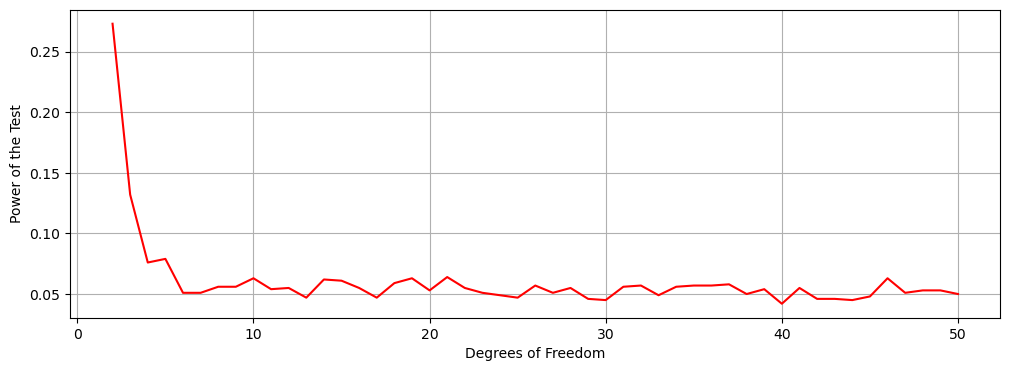

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(dfs, emp_sizes, color='r')
plt.xlabel('Degrees of Freedom')
plt.ylabel('Power of the Test')
plt.grid()

Here we can see that at the beginning, when the degrees of freedom is small - the power of the test is high. It's natural, because we have $t$-distribution, which differs from the normal one.

As we expected, when the degrees of freedom increases the probability of rejecting incorrect $H_0$ (power of the test) decreases as $t$-distribution becomes more similar to normal one.

So, we can conclude that Kolmogorov-Smirnov test is quite reliable for detecting non-normal distributions, which are significantly different from a normal one, but in case when distribution doesn't differ a lot from the normal distribution, the test is not powerful (power of the test is low). In such case the test "recognizes" such distribution as normal one.